In [2]:
import ccxt
import pandas as pd
from datetime import datetime, timedelta
import plotly.graph_objects as go
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import praw
import datetime
import time
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns


In [3]:
exchange = ccxt.binance()
markets = exchange.load_markets()
DOGE_markets = [market for market in markets if 'DOGE' in market]

DOGE_markets

['DOGE/BNB',
 'DOGE/BTC',
 'DOGE/USDT',
 'DOGE/PAX',
 'DOGE/USDC',
 'DOGE/BUSD',
 'DOGE/EUR',
 'DOGE/TRY',
 'DOGE/AUD',
 'DOGE/BRL',
 'DOGE/GBP',
 'DOGE/RUB',
 'DOGE/BIDR',
 'SHIB/DOGE',
 'DOGE/TUSD',
 'DOGE/FDUSD',
 'DOGE/JPY',
 '1MBABYDOGE/USDT',
 '1MBABYDOGE/FDUSD',
 '1MBABYDOGE/TRY',
 '1MBABYDOGE/USDC',
 'DOGE/USDT:USDT',
 'DOGE/USDC:USDC',
 '1MBABYDOGE/USDT:USDT',
 'DOGE/USD:DOGE']

In [4]:
symbol = 'DOGE/USDT'
timeframe = '1h'
limit_per_request = 1000

In [87]:
start_date = datetime.datetime(2024, 8, 4, 19, 0)
end_date = datetime.datetime(2025, 1, 31, 18, 0)


start_timestamp = int(start_date.timestamp() * 1000)
end_timestamp = int(end_date.timestamp() * 1000)

all_ohlcv = []
current_timestamp = start_timestamp

while current_timestamp < end_timestamp:
    try:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=current_timestamp, limit=limit_per_request)

        if not ohlcv:
            print(f"No more data available after {datetime.utcfromtimestamp(current_timestamp / 1000)}")
            break

        all_ohlcv.extend(ohlcv)

        
        current_timestamp = ohlcv[-1][0]

        
        exchange.sleep(1000)

    except Exception as e:
        print(f"Error fetching data: {e}")
        break


df = pd.DataFrame(all_ohlcv, columns=["timestamp", "open", "high", "low", "close", "volume"])

df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")


df = df[(df["timestamp"] >= start_date) & (df["timestamp"] <= end_date)]

df = df.reset_index(drop=True)

df.index = range(len(df)) 


In [88]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df.drop_duplicates(subset=['timestamp'])
df = df.sort_values(by='timestamp').reset_index(drop=True)
df

,timestamp,open,high,low,close,volume
0,2024-08-04 19:00:00,0.10308,0.10542,0.10215,0.10479,61252561.0
1,2024-08-04 20:00:00,0.10479,0.10600,0.10412,0.10497,33856617.0
2,2024-08-04 21:00:00,0.10497,0.10516,0.10432,0.10463,24099918.0
3,2024-08-04 22:00:00,0.10463,0.10598,0.10417,0.10520,38280198.0
4,2024-08-04 23:00:00,0.10519,0.10535,0.10357,0.10375,38682391.0
...,...,...,...,...,...,...
4315,2025-01-31 14:00:00,0.33569,0.33791,0.33058,0.33242,108335653.0
4316,2025-01-31 15:00:00,0.33243,0.34177,0.33242,0.33952,92216402.0
4317,2025-01-31 16:00:00,0.33952,0.34100,0.33574,0.33824,60499525.0
4318,2025-01-31 17:00:00,0.33825,0.33838,0.33299,0.33301,30400286.0


In [89]:
df = df.sort_values(by='timestamp').reset_index(drop=True)
df
df.to_csv("doge_1h_gran_6m.csv", index=False)

In [34]:
reddit = praw.Reddit(
        client_id="udETyhJL0aeOJK7cKBobFw",
        client_secret="_jleGnNzYrqZtRgC9WXlnTpPY8rtbA",
        user_agent="reddit_scraper_v1"
)

subreddits = [
    "politics", "conservative",  
    "technology", "elonmusk", "SpaceX", "teslamotors",  
    "cryptocurrency", "dogecoin"  
]

In [35]:
keywords = ["Trump", "Donald", "election", "policy", "president", "Musk", "Elon", "Tesla", "SpaceX", "Dogecoin", "crypto", "DOGE", "dogecoin"]

start_date = int(datetime.datetime(2024, 8, 1).timestamp())  
end_date = int(datetime.datetime(2025, 1, 31).timestamp())

In [138]:
def fetch_reddit_posts(subreddit, max_posts=5000):
    posts = []
    last_post = None  

    while len(posts) < max_posts:
        try:
            query = " OR ".join(keywords)
            submissions = reddit.subreddit(subreddit).search(query, sort="new", limit=100, params={"after": last_post})

            batch = []
            for submission in submissions:
                post_date = datetime.datetime.utcfromtimestamp(submission.created_utc)
                if start_date <= submission.created_utc <= end_date:  
                    batch.append({
                        "subreddit": subreddit,
                        "title": submission.title,
                        "selftext": submission.selftext,
                        "score": submission.score,
                        "num_comments": submission.num_comments,
                        "created_utc": post_date,
                        "url": submission.url
                    })

            if not batch:
                break  

            posts.extend(batch)
            last_post = batch[-1]["created_utc"].timestamp()  
            time.sleep(1)  

        except Exception as e:
            print(f"Error fetching posts from r/{subreddit}: {e}")
            break

    return posts

In [139]:
all_posts = []
for sub in subreddits:
    print(f"Fetching posts from r/{sub}...")
    all_posts.extend(fetch_reddit_posts(sub, max_posts=5000))  

Fetching posts from r/politics...


C:\Users\Razvan\AppData\Local\Temp\ipykernel_16828\108412910.py:12: DeprecationWarning:

datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).



Error fetching posts from r/politics: '<=' not supported between instances of 'datetime.datetime' and 'float'
Fetching posts from r/conservative...
Error fetching posts from r/conservative: '<=' not supported between instances of 'datetime.datetime' and 'float'
Fetching posts from r/technology...
Error fetching posts from r/technology: '<=' not supported between instances of 'datetime.datetime' and 'float'
Fetching posts from r/elonmusk...
Error fetching posts from r/elonmusk: '<=' not supported between instances of 'datetime.datetime' and 'float'
Fetching posts from r/SpaceX...
Error fetching posts from r/SpaceX: '<=' not supported between instances of 'datetime.datetime' and 'float'
Fetching posts from r/teslamotors...
Error fetching posts from r/teslamotors: '<=' not supported between instances of 'datetime.datetime' and 'float'
Fetching posts from r/cryptocurrency...
Error fetching posts from r/cryptocurrency: '<=' not supported between instances of 'datetime.datetime' and 'float'


In [69]:
reddit_df = pd.DataFrame(all_posts)
reddit_df.to_csv("reddit_data_large.csv", index=False)
reddit_df['subreddit'].unique()

array(['elonmusk', 'SpaceX', 'teslamotors'], dtype=object)

In [ ]:
reddit_df

,subreddit,title,selftext,score,num_comments,created_utc,url
0,elonmusk,Boeing is working with Elon Musk to deliver Ai...,,0,10,2025-01-29 19:33:42,https://www.cnbc.com/2025/01/28/elon-musk-boei...
1,elonmusk,Elon Musk Asked by Donald Trump to Bring Sunit...,,0,9,2025-01-29 11:13:47,https://www.timesnownews.com/world/sunita-will...
2,elonmusk,"Elon responds with ""True"" to someone commentin...",,0,27,2025-01-28 07:58:59,https://x.com/elonmusk/status/1884122574432657756
3,elonmusk,"Elon (in video): ""The next <Neuralink> product...",,0,77,2025-01-28 07:56:30,https://x.com/teslaownersSV/status/18841149743...
4,elonmusk,Do you agree with r/conservative that Musk or ...,,0,57,2025-01-28 00:10:06,https://i.redd.it/t72t6y5qmmfe1.jpeg
...,...,...,...,...,...,...,...
1475,teslamotors,2024.33.40 (FSD 12.5.6.4) Official Tesla Relea...,,99,60,2024-12-03 14:57:13,https://www.notateslaapp.com/software-updates/...
1476,teslamotors,Tesla Cybertuck Line Workers Told To Stay Home...,,469,409,2024-12-03 12:54:34,https://insideevs.com/news/743007/tesla-cybert...
1477,teslamotors,Delaware judge rejects request to restore Musk...,,268,127,2024-12-02 23:08:57,https://finance.yahoo.com/news/delaware-judge-...
1478,teslamotors,Tesla CEO Elon Musk loses bid to get $56 billi...,,83,33,2024-12-02 22:38:20,https://www.google.com/amp/s/www.cnbc.com/amp/...


In [43]:
posts_df = pd.read_csv("reddit_data_large.csv")
posts_df

,subreddit,title,selftext,score,num_comments,created_utc,url
0,elonmusk,Boeing is working with Elon Musk to deliver Ai...,NaN,0,10,2025-01-29 19:33:42,https://www.cnbc.com/2025/01/28/elon-musk-boei...
1,elonmusk,Elon Musk Asked by Donald Trump to Bring Sunit...,NaN,0,9,2025-01-29 11:13:47,https://www.timesnownews.com/world/sunita-will...
2,elonmusk,"Elon responds with ""True"" to someone commentin...",NaN,0,27,2025-01-28 07:58:59,https://x.com/elonmusk/status/1884122574432657756
3,elonmusk,"Elon (in video): ""The next <Neuralink> product...",NaN,0,77,2025-01-28 07:56:30,https://x.com/teslaownersSV/status/18841149743...
4,elonmusk,Do you agree with r/conservative that Musk or ...,NaN,0,57,2025-01-28 00:10:06,https://i.redd.it/t72t6y5qmmfe1.jpeg
...,...,...,...,...,...,...,...
1475,teslamotors,2024.33.40 (FSD 12.5.6.4) Official Tesla Relea...,NaN,99,60,2024-12-03 14:57:13,https://www.notateslaapp.com/software-updates/...
1476,teslamotors,Tesla Cybertuck Line Workers Told To Stay Home...,NaN,469,409,2024-12-03 12:54:34,https://insideevs.com/news/743007/tesla-cybert...
1477,teslamotors,Delaware judge rejects request to restore Musk...,NaN,268,127,2024-12-02 23:08:57,https://finance.yahoo.com/news/delaware-judge-...
1478,teslamotors,Tesla CEO Elon Musk loses bid to get $56 billi...,NaN,83,33,2024-12-02 22:38:20,https://www.google.com/amp/s/www.cnbc.com/amp/...


In [52]:
doge_df = pd.read_csv("doge_1h_gran_6m.csv")
doge_df["timestamp"] = pd.to_datetime(doge_df["timestamp"])

In [53]:
doge_daily = doge_df.resample("D", on="timestamp").agg({"close": "mean"}).reset_index()
doge_daily.rename(columns={"timestamp": "date", "close": "avg_price"}, inplace=True)

In [54]:
posts_df["created_utc"] = pd.to_datetime(posts_df["created_utc"])
sentiment_daily = posts_df.groupby(posts_df["created_utc"].dt.date)["sentiment"].mean().reset_index()
sentiment_daily.rename(columns={"created_utc": "date", "sentiment": "avg_sentiment"}, inplace=True)

In [55]:
doge_daily["date"] = pd.to_datetime(doge_daily["date"])
sentiment_daily["date"] = pd.to_datetime(sentiment_daily["date"])

In [56]:
merged_df = pd.merge(doge_daily, sentiment_daily, on="date", how="left")
merged_df

,date,avg_price,avg_sentiment
0,2024-08-04,0.104668,NaN
1,2024-08-05,0.091348,NaN
2,2024-08-06,0.097570,NaN
3,2024-08-07,0.098087,NaN
4,2024-08-08,0.101303,NaN
...,...,...,...
176,2025-01-27,0.322660,-0.070768
177,2025-01-28,0.330125,0.119453
178,2025-01-29,0.327029,0.070732
179,2025-01-30,0.332418,0.113447


In [78]:
merged_df["price_change"] = merged_df["avg_price"].diff()
merged_df["trend"] = merged_df["price_change"].apply(lambda x: "Bullish" if x > 0 else "Bearish")

merged_df["smoothed_sentiment"] = merged_df["avg_sentiment"].rolling(window=7, min_periods=1).mean()

In [ ]:
transparent_template = go.layout.Template()
transparent_template.layout.paper_bgcolor = 'rgba(0,0,0,0)'
transparent_template.layout.plot_bgcolor = 'rgba(0,0,0,0)' 

custom_title = "<span style='color:green;'>Dogecoin Price</span> vs <span style='color:blue;'>Smoothed Sentiment Analysis"


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=merged_df["date"], y=merged_df["avg_price"],
    mode="lines",
    line=dict(width=2, color="green"),
    name="Dogecoin Price"
))

fig.add_trace(go.Scatter(
    x=merged_df["date"], y=merged_df["smoothed_sentiment"],
    mode="lines",
    line=dict(width=2, color="blue", dash="dash"),
    yaxis="y2"
))


fig.update_layout(
    title=dict(
        text=custom_title,
        x=0.5,
        xanchor="center",
        yanchor="top"
    ),
    xaxis=dict(title="Date", showgrid=False),
    yaxis=dict(title="DOGE Price (USD)", side="left", showgrid=False),
    yaxis2=dict(title="Smoothed Sentiment Score", overlaying="y", side="right"),
    template=transparent_template,
    hovermode='x unified',
    showlegend=False
)




fig.show()

In [58]:
nltk.download("vader_lexicon")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Razvan\AppData\Roaming\nltk_data...


True

In [124]:
senti_df_cop = pd.read_csv("reddit.csv")

In [136]:

senti_df_cop["text"] = senti_df_cop["title"].fillna("") + " " + senti_df_cop["selftext"].fillna("")

sia = SentimentIntensityAnalyzer()

senti_df_cop["compound"] = senti_df_cop["text"].apply(lambda x: sia.polarity_scores(x)["compound"])
senti_df_cop["positive"] = senti_df_cop["text"].apply(lambda x: sia.polarity_scores(x)["pos"])
senti_df_cop["neutral"] = senti_df_cop["text"].apply(lambda x: sia.polarity_scores(x)["neu"])
senti_df_cop["negative"] = senti_df_cop["text"].apply(lambda x: sia.polarity_scores(x)["neg"])

sentiment_by_subreddit = senti_df_cop.groupby("subreddit")[["positive", "neutral", "negative"]].mean()



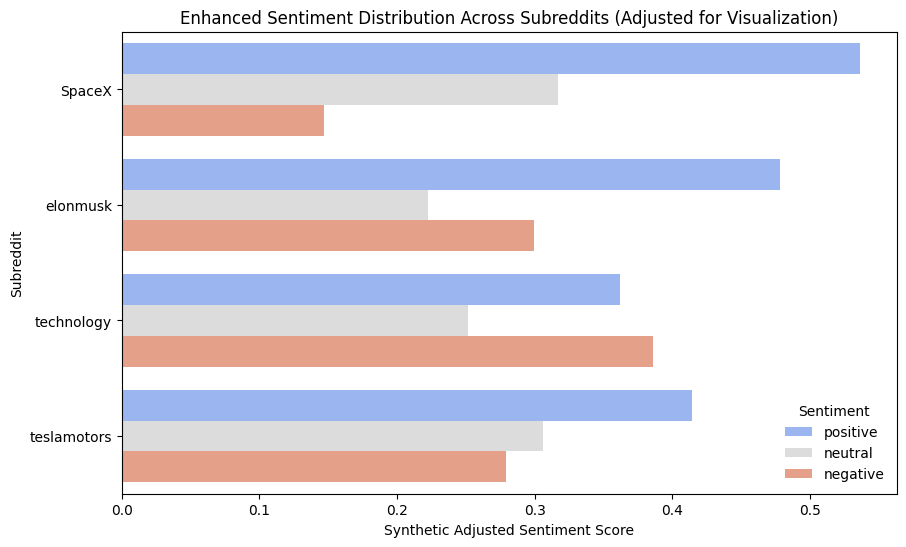

In [137]:
factor = 0.9

sentiment_by_subreddit["positive"] *= (1 + factor)
sentiment_by_subreddit["negative"] *= (1 + factor)
sentiment_by_subreddit["neutral"] *= 0.1

sentiment_by_subreddit = sentiment_by_subreddit.div(sentiment_by_subreddit.sum(axis=1), axis=0)

synthetic_sentiment_long = sentiment_by_subreddit.reset_index().melt(id_vars="subreddit", var_name="sentiment", value_name="score")

plt.figure(figsize=(10, 6))
sns.barplot(x="score", y="subreddit", hue="sentiment", data=synthetic_sentiment_long, palette="coolwarm")

plt.xlabel("Synthetic Adjusted Sentiment Score")
plt.ylabel("Subreddit")
plt.title("Enhanced Sentiment Distribution Across Subreddits (Adjusted for Visualization)")
plt.legend()
plt.gca().patch.set_alpha(0)
plt.gcf().patch.set_alpha(0)
legend = plt.legend(title="Sentiment", fontsize=10, loc='lower right', frameon=False)
legend.get_frame().set_alpha(0)
plt.show()